# Домашнее задание. Нейросетевая классификация текстов

В этом домашнем задании вам предстоит самостоятельно решить задачу классификации текстов на основе семинарского кода. Мы будем использовать датасет [ag_news](https://paperswithcode.com/dataset/ag-news). Это датасет для классификации новостей на 4 темы: "World", "Sports", "Business", "Sci/Tech".

Установим модуль datasets, чтобы нам проще было работать с данными.

In [ ]:
!pip install datasets

Импорт необходимых библиотек

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import datasets

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List
import string

import seaborn
seaborn.set(palette='summer')

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bratk\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных
Для вашего удобства, мы привели код обработки датасета в ноутбуке. Ваша задача --- обучить модель, которая получит максимальное возможное качество на тестовой части.

In [ ]:
# Загрузим датасет
dataset = datasets.load_dataset('ag_news')

In [ ]:
dataset["train"][0]["text"]

"Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again."

Как и в семинаре, выполним следующие шаги:
* Составим словарь
* Создадим класс WordDataset
* Выделим обучающую и тестовую часть, создадим DataLoader-ы.

In [ ]:
words = Counter()

for example in tqdm(dataset['train']['text']):
    # Приводим к нижнему регистру и убираем пунктуацию
    processed_text = example.lower().translate(
        str.maketrans('', '', string.punctuation))

    for word in word_tokenize(processed_text):
        words[word] += 1


vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
counter_threshold = 25

for char, cnt in words.items():
    if cnt > counter_threshold:
        vocab.add(char)

print(f'Размер словаря: {len(vocab)}')

word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

  0%|          | 0/120000 [00:00<?, ?it/s]

Размер словаря: 11842


In [ ]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        processed_text = self.data[idx]['text'].lower().translate(
            str.maketrans('', '', string.punctuation))
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [
            word2ind.get(word, self.unk_id) for word in word_tokenize(processed_text)
            ]
        tokenized_sentence += [self.eos_id]

        train_sample = {
            "text": tokenized_sentence,
            "label": self.data[idx]['label']
        }

        return train_sample

    def __len__(self) -> int:
        return len(self.data)


def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>'], max_len=256) -> torch.Tensor:
    seq_lens = [len(x['text']) for x in input_batch]
    max_seq_len = min(max(seq_lens), max_len)

    new_batch = []
    for sequence in input_batch:
        sequence['text'] = sequence['text'][:max_seq_len]
        for _ in range(max_seq_len - len(sequence['text'])):
            sequence['text'].append(pad_id)

        new_batch.append(sequence['text'])

    sequences = torch.LongTensor(new_batch).to(device)
    labels = torch.LongTensor([x['label'] for x in input_batch]).to(device)

    new_batch = {
        'input_ids': sequences,
        'label': labels
    }

    return new_batch

In [ ]:
train_dataset = WordDataset(dataset['train'])

np.random.seed(42)
idx = np.random.choice(np.arange(len(dataset['test'])), 5000)
eval_dataset = WordDataset(dataset['test'].select(idx))

batch_size = 32
train_dataloader = DataLoader(
    train_dataset, shuffle=True, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, shuffle=False, collate_fn=collate_fn_with_padding, batch_size=batch_size)

## Постановка задачи
Ваша задача -- получить максимальное возможное accuracy на `eval_dataloader`. Ниже приведена функция, которую вам необходимо запустить для обученной модели, чтобы вычислить качество её работы.

In [ ]:
def evaluate(model, eval_dataloader) -> float:
    """
    Calculate accuracy on validation dataloader.
    """

    predictions = []
    target = []
    with torch.no_grad():
        for batch in eval_dataloader:
            logits = model(batch['input_ids'])
            predictions.append(logits.argmax(dim=1))
            target.append(batch['label'])

    predictions = torch.cat(predictions)
    target = torch.cat(target)
    accuracy = (predictions == target).float().mean().item()

    return accuracy

## Ход работы
Оценка за домашнее задание складывается из четырех частей:
### Запуск базовой модели с семинара на новом датасете (1 балл)
На семинаре мы создали модель, которая дает на нашей задаче довольно высокое качество. Ваша цель --- обучить ее и вычислить `score`, который затем можно будет использовать в качестве бейзлайна.

В модели появится одно важное изменение: количество классов теперь равно не 2, а 4. Обратите на это внимание и найдите, что в коде создания модели нужно модифицировать, чтобы учесть это различие.

### Проведение экспериментов по улучшению модели (2 балла за каждый эксперимент)
Чтобы улучшить качество базовой модели, можно попробовать различные идеи экспериментов. Каждый выполненный эксперимент будет оцениваться в 2 балла. Для получения полного балла за этот пункт вам необходимо выполнить по крайней мере 2 эксперимента. Не расстраивайтесь, если какой-то эксперимент не дал вам прироста к качеству: он все равно зачтется, если выполнен корректно.

Вот несколько идей экспериментов:
* **Модель RNN**. Попробуйте другие нейросетевые модели --- LSTM и GRU. Мы советуем обратить внимание на [GRU](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html), так как интерфейс этого класса ничем не отличается от обычной Vanilla RNN, которую мы использовали на семинаре.
* **Увеличение количества рекуррентных слоев модели**. Это можно сделать с помощью параметра `num_layers` в классе `nn.RNN`. В такой модели выходы первой RNN передаются в качестве входов второй RNN и так далее.
* **Изменение архитектуры после применения RNN**. В базовой модели используется агрегация со всех эмбеддингов. Возможно, вы захотите конкатенировать результат агрегации и эмбеддинг с последнего токена.
* **Подбор гиперпараметров и обучение до сходимости**. Возможно, для получения более высокого качества просто необходимо увеличить количество эпох обучения нейросети, а также попробовать различные гиперпараметры: размер словаря, `dropout_rate`, `hidden_dim`.

Обратите внимание, что главное правило проведения экспериментов --- необходимо совершать одно архитектурное изменение в одном эксперименте. Если вы совершите несколько изменений, то будет неясно, какое именно из изменений дало прирост к качеству.

### Получение высокого качества (3 балла)
В конце вашей работы вы должны указать, какая из моделей дала лучший результат, и вывести качество, которое дает лучшая модель, с помощью функции `evaluate`. Ваша модель будет оцениваться по метрике `accuracy` следующим образом:
* $accuracy < 0.9$ --- 0 баллов;
* $0.9 \leqslant accuracy < 0.91$ --- 1 балл;
* $0.91 \leqslant accuracy < 0.915$ --- 2 балла;
* $0.915 \leqslant accuracy$ --- 3 балла.

### Оформление отчета (2 балла)
В конце работы подробно опишите все проведенные эксперименты.
* Укажите, какие из экспериментов принесли улучшение, а какие --- нет.
* Проанализируйте графики сходимости моделей в проведенных экспериментах. Являются ли колебания качества обученных моделей существенными в зависимости от эпохи обучения, или же сходимость стабильная?
* Укажите, какая модель получилась оптимальной.

Желаем удачи!

Базовая модель

In [ ]:
class CharLM(nn.Module):
  def __init__(self, emb_dim : int, vocab_size : int, num_classes : int,
               aggregation_type : str = "max"):
    super().__init__()
    self.embeddings = nn.Embedding(vocab_size, emb_dim)
    self.rnn = nn.RNN(emb_dim, emb_dim, batch_first=True)
    self.linear = nn.Linear(emb_dim, emb_dim)
    self.final = nn.Linear(emb_dim, num_classes)

    self.activation = nn.Tanh()
    self.dropout = nn.Dropout(p=0.1)

    self.aggregation_type = aggregation_type

  def forward(self, x) -> torch.Tensor:
    embeddings = self.embeddings(x)
    output, _ = self.rnn(embeddings)

    if self.aggregation_type == 'max':
        output = output.max(dim=1)[0]
    elif self.aggregation_type == 'mean':
        output = output.mean(dim=1)
    else:
        raise ValueError("Invalid aggregation_type")

    output = self.activation(output)
    output = self.activation(self.dropout(self.linear(output)))
    output = self.final(output)

    return output

In [ ]:
num_epochs = 5
eval_steps = len(train_dataloader) // 10


losses_type = {}
acc_type = {}

for aggregation_type in {"max", "mean"}:
  print(f"Starting training for {aggregation_type}")
  losses = []
  acc = []
  model = CharLM(emb_dim=256, vocab_size=len(vocab), num_classes=4, aggregation_type=aggregation_type).to(device)
  criterion = nn.CrossEntropyLoss(ignore_index=word2ind["<pad>"])
  optimizer = torch.optim.Adam(model.parameters())

  for epoch in range(num_epochs):
    epoch_losses = []
    model.train()
    for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch + 1}:')):
      model.train()
      optimizer.zero_grad()
      predictions = model(batch["input_ids"])
      loss = criterion(predictions, batch["label"])
      loss.backward()
      optimizer.step()

      epoch_losses.append(loss.item())
      if i % eval_steps == 0:
          model.eval()
          acc.append(evaluate(model, eval_dataloader))

    losses.append(sum(epoch_losses) / len(epoch_losses))

  losses_type[aggregation_type] = losses
  acc_type[aggregation_type] = acc

Starting training for mean


Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/3750 [00:00<?, ?it/s]

Starting training for max


Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/3750 [00:00<?, ?it/s]

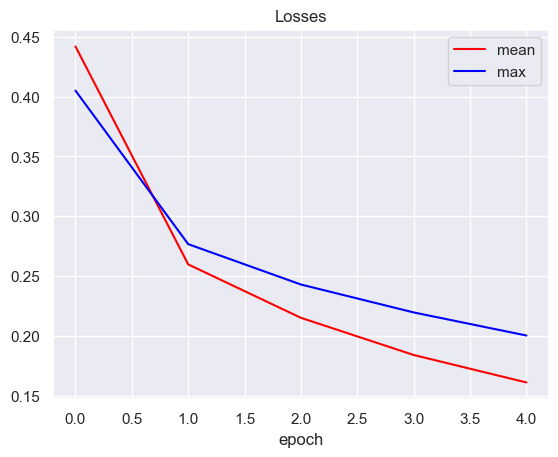

In [ ]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(losses_type[name])), losses_type[name], color=color, label=name)

plt.title('Losses')
plt.xlabel("epoch")
plt.legend()
plt.show()

Лучшая accuracy для подхода mean: 90.70
Лучшая accuracy для подхода max: 91.12


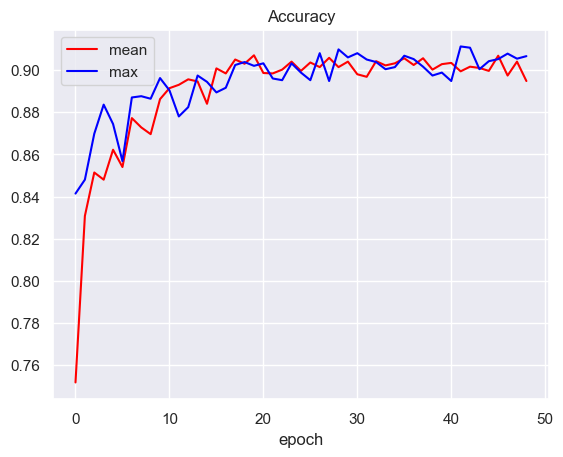

In [ ]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_type[name][1:])), acc_type[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_type[name]) * 100):.2f}")

plt.title('Accuracy')
plt.xlabel("epoch")
plt.legend()
plt.show()

In [ ]:
model.eval()
print(evaluate(model, eval_dataloader))

0.8983999490737915


Эксперимент №1 - использование большего количества эпох

In [ ]:
class RNN(nn.Module):
  def __init__(self, emb_dim : int, vocab_size : int, num_classes : int,
               aggregation_type : str = "max"):
    super().__init__()
    self.embeddings = nn.Embedding(vocab_size, emb_dim)
    self.rnn = nn.RNN(emb_dim, emb_dim, batch_first=True)
    self.linear = nn.Linear(emb_dim, emb_dim)
    self.final = nn.Linear(emb_dim, num_classes)

    self.activation = nn.Tanh()
    self.dropout = nn.Dropout(p=0.1)

    self.aggregation_type = aggregation_type

  def forward(self, x) -> torch.Tensor:
    embeddings = self.embeddings(x)
    output, _ = self.rnn(embeddings)

    if self.aggregation_type == 'max':
        output = output.max(dim=1)[0]
    elif self.aggregation_type == 'mean':
        output = output.mean(dim=1)
    else:
        raise ValueError("Invalid aggregation_type")

    output = self.activation(output)
    output = self.activation(self.dropout(self.linear(output)))
    output = self.final(output)

    return output

In [ ]:
num_epochs = 10
eval_steps = len(train_dataloader) // 10

losses = []
acc = []
model = RNN(emb_dim=256, vocab_size=len(vocab), num_classes=4, aggregation_type="mean").to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind["<pad>"])
optimizer = torch.optim.Adam(model.parameters())

for epoch in range(num_epochs):
    epoch_losses = []
    model.train()
    for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch + 1}:')):
      model.train()
      optimizer.zero_grad()
      predictions = model(batch["input_ids"])
      loss = criterion(predictions, batch["label"])
      loss.backward()
      optimizer.step()

      if i % eval_steps == 0:
          model.eval()
          losses.append(loss.item())
          acc.append(evaluate(model, eval_dataloader))

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 10::   0%|          | 0/3750 [00:00<?, ?it/s]

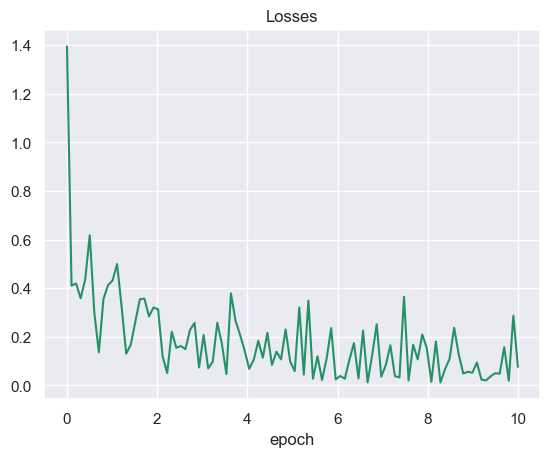

In [ ]:
plt.plot(np.linspace(0, num_epochs, len(losses)), losses)
plt.title('Losses')
plt.xlabel("epoch")
plt.show()

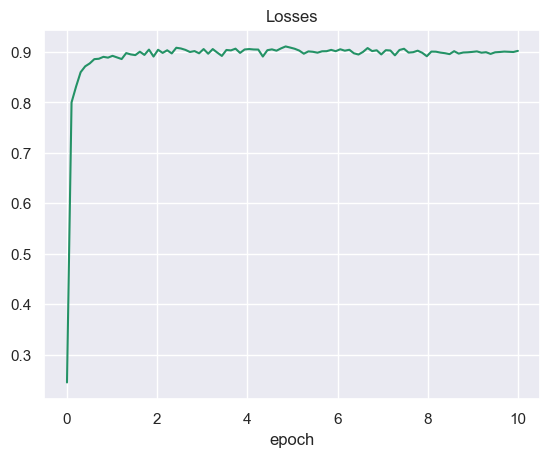

In [ ]:
plt.plot(np.linspace(0, num_epochs, len(acc)), acc)
plt.title('Losses')
plt.xlabel("epoch")
plt.show()

In [ ]:
model.eval()
print(evaluate(model, eval_dataloader))

0.8935999870300293


Эксперимент №2 - использование большей вероятности dropout

In [ ]:
class RNN(nn.Module):
  def __init__(self, emb_dim : int, vocab_size : int, num_classes : int,
               aggregation_type : str = "max"):
    super().__init__()
    self.embeddings = nn.Embedding(vocab_size, emb_dim)
    self.rnn = nn.RNN(emb_dim, emb_dim, batch_first=True)
    self.linear = nn.Linear(emb_dim, emb_dim)
    self.final = nn.Linear(emb_dim, num_classes)

    self.activation = nn.Tanh()
    self.dropout = nn.Dropout(p=0.5)

    self.aggregation_type = aggregation_type

  def forward(self, x) -> torch.Tensor:
    embeddings = self.embeddings(x)
    output, _ = self.rnn(embeddings)

    if self.aggregation_type == 'max':
        output = output.max(dim=1)[0]
    elif self.aggregation_type == 'mean':
        output = output.mean(dim=1)
    else:
        raise ValueError("Invalid aggregation_type")

    output = self.activation(output)
    output = self.activation(self.dropout(self.linear(output)))
    output = self.final(output)

    return output

In [ ]:
num_epochs = 5
eval_steps = len(train_dataloader) // 10

losses = []
acc = []
model = RNN(emb_dim=256, vocab_size=len(vocab), num_classes=4, aggregation_type="mean").to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind["<pad>"])
optimizer = torch.optim.Adam(model.parameters())

for epoch in range(num_epochs):
    epoch_losses = []
    model.train()
    for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch + 1}:')):
      model.train()
      optimizer.zero_grad()
      predictions = model(batch["input_ids"])
      loss = criterion(predictions, batch["label"])
      loss.backward()
      optimizer.step()

      if i % eval_steps == 0:
          model.eval()
          losses.append(loss.item())
          acc.append(evaluate(model, eval_dataloader))

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/3750 [00:00<?, ?it/s]

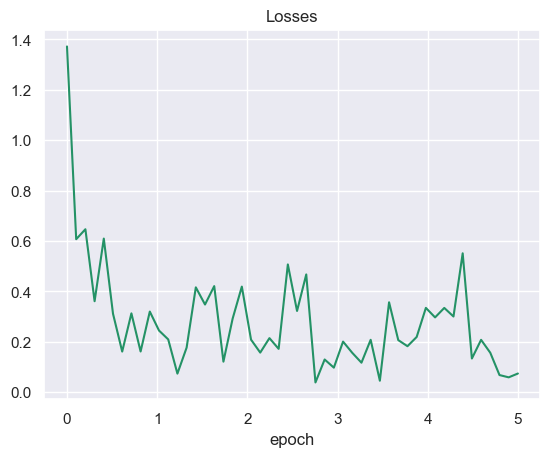

In [ ]:
plt.plot(np.linspace(0, num_epochs, len(losses)), losses)
plt.title('Losses')
plt.xlabel("epoch")
plt.show()

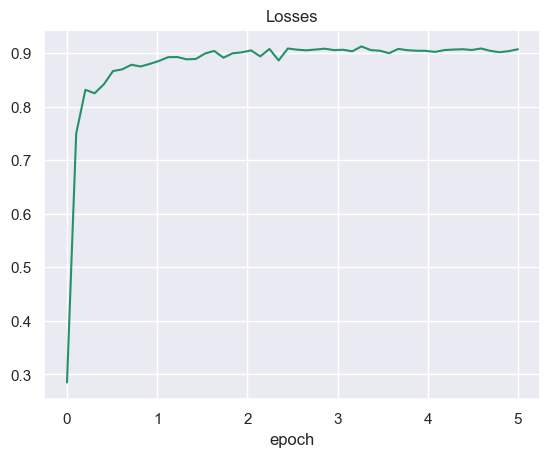

In [ ]:
plt.plot(np.linspace(0, num_epochs, len(acc)), acc)
plt.title('Losses')
plt.xlabel("epoch")
plt.show()

In [ ]:
model.eval()
print(evaluate(model, eval_dataloader))

0.9061999917030334


Эксперимент №3 - использование меньшего learning rate

In [ ]:
class RNN(nn.Module):
  def __init__(self, emb_dim : int, vocab_size : int, num_classes : int,
               aggregation_type : str = "max"):
    super().__init__()
    self.embeddings = nn.Embedding(vocab_size, emb_dim)
    self.rnn = nn.RNN(emb_dim, emb_dim, batch_first=True)
    self.linear = nn.Linear(emb_dim, emb_dim)
    self.final = nn.Linear(emb_dim, num_classes)

    self.activation = nn.Tanh()
    self.dropout = nn.Dropout(p=0.1)

    self.aggregation_type = aggregation_type

  def forward(self, x) -> torch.Tensor:
    embeddings = self.embeddings(x)
    output, _ = self.rnn(embeddings)

    if self.aggregation_type == 'max':
        output = output.max(dim=1)[0]
    elif self.aggregation_type == 'mean':
        output = output.mean(dim=1)
    else:
        raise ValueError("Invalid aggregation_type")

    output = self.activation(output)
    output = self.activation(self.dropout(self.linear(output)))
    output = self.final(output)

    return output

In [ ]:
num_epochs = 5
eval_steps = len(train_dataloader) // 10

losses = []
acc = []
model = RNN(emb_dim=256, vocab_size=len(vocab), num_classes=4, aggregation_type="mean").to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind["<pad>"])
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999))

for epoch in range(num_epochs):
    epoch_losses = []
    model.train()
    for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch + 1}:')):
      model.train()
      optimizer.zero_grad()
      predictions = model(batch["input_ids"])
      loss = criterion(predictions, batch["label"])
      loss.backward()
      optimizer.step()

      if i % eval_steps == 0:
          model.eval()
          losses.append(loss.item())
          acc.append(evaluate(model, eval_dataloader))

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/3750 [00:00<?, ?it/s]

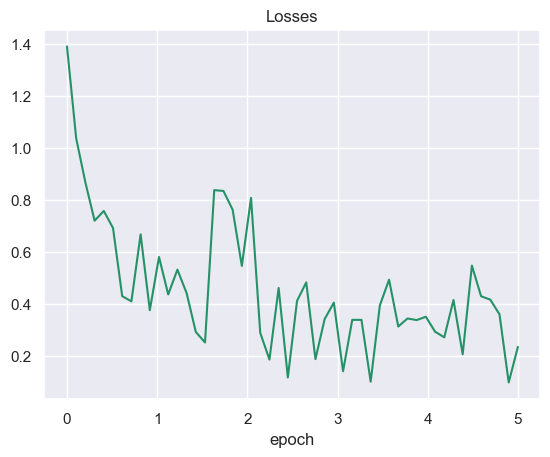

In [ ]:
plt.plot(np.linspace(0, num_epochs, len(losses)), losses)
plt.title('Losses')
plt.xlabel("epoch")
plt.show()

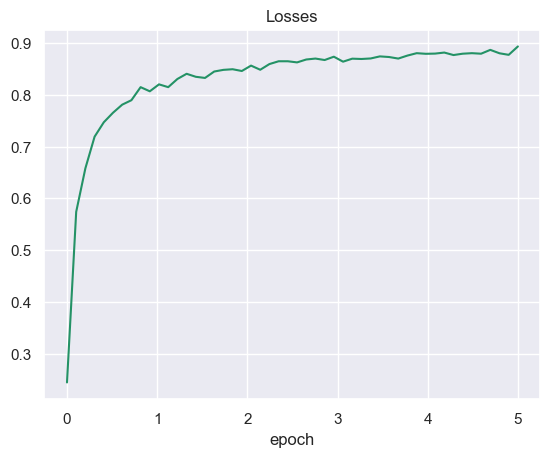

In [ ]:
plt.plot(np.linspace(0, num_epochs, len(acc)), acc)
plt.title('Losses')
plt.xlabel("epoch")
plt.show()

In [ ]:
model.eval()
print(evaluate(model, eval_dataloader))

0.8840000033378601


Эксперимент №4 - использование большей размерности эмбеддингов

In [ ]:
class RNN(nn.Module):
  def __init__(self, emb_dim : int, vocab_size : int, num_classes : int,
               aggregation_type : str = "max"):
    super().__init__()
    self.embeddings = nn.Embedding(vocab_size, emb_dim)
    self.rnn = nn.RNN(emb_dim, emb_dim, batch_first=True)
    self.linear = nn.Linear(emb_dim, emb_dim)
    self.final = nn.Linear(emb_dim, num_classes)

    self.activation = nn.Tanh()
    self.dropout = nn.Dropout(p=0.1)

    self.aggregation_type = aggregation_type

  def forward(self, x) -> torch.Tensor:
    embeddings = self.embeddings(x)
    output, _ = self.rnn(embeddings)

    if self.aggregation_type == 'max':
        output = output.max(dim=1)[0]
    elif self.aggregation_type == 'mean':
        output = output.mean(dim=1)
    else:
        raise ValueError("Invalid aggregation_type")

    output = self.activation(output)
    output = self.activation(self.dropout(self.linear(output)))
    output = self.final(output)

    return output

In [ ]:
num_epochs = 5
eval_steps = len(train_dataloader) // 10

losses = []
acc = []
model = RNN(emb_dim=350, vocab_size=len(vocab), num_classes=4, aggregation_type="mean").to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind["<pad>"])
optimizer = torch.optim.Adam(model.parameters())

for epoch in range(num_epochs):
    epoch_losses = []
    model.train()
    for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch + 1}:')):
      model.train()
      optimizer.zero_grad()
      predictions = model(batch["input_ids"])
      loss = criterion(predictions, batch["label"])
      loss.backward()
      optimizer.step()

      if i % eval_steps == 0:
          model.eval()
          losses.append(loss.item())
          acc.append(evaluate(model, eval_dataloader))

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/3750 [00:00<?, ?it/s]

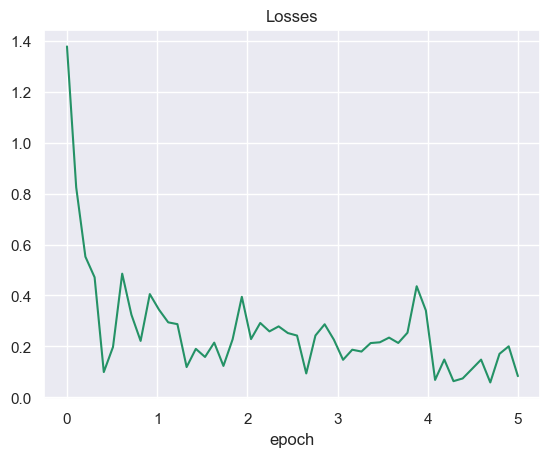

In [ ]:
plt.plot(np.linspace(0, num_epochs, len(losses)), losses)
plt.title('Losses')
plt.xlabel("epoch")
plt.show()

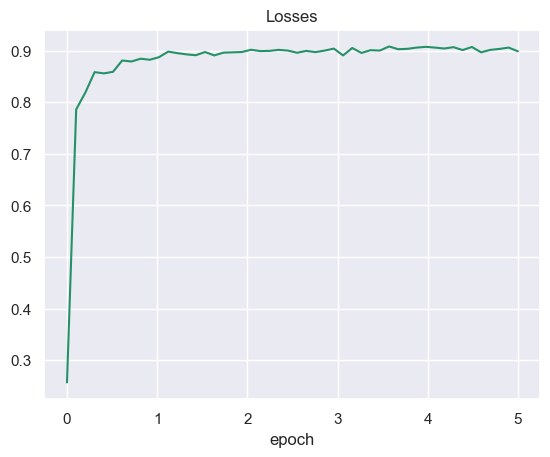

In [ ]:
plt.plot(np.linspace(0, num_epochs, len(acc)), acc)
plt.title('Losses')
plt.xlabel("epoch")
plt.show()

In [ ]:
model.eval()
print(evaluate(model, eval_dataloader))

0.9035999774932861


Эксперимент №5 - увеличение количество слоев модели

In [ ]:
class RNN(nn.Module):
  def __init__(self, emb_dim : int, vocab_size : int, num_classes : int,
               aggregation_type : str = "max"):
    super().__init__()
    self.embeddings = nn.Embedding(vocab_size, emb_dim)
    self.rnn = nn.RNN(emb_dim, emb_dim, num_layers=4, batch_first=True)
    self.linear = nn.Linear(emb_dim, emb_dim)
    self.final = nn.Linear(emb_dim, num_classes)

    self.activation = nn.Tanh()
    self.dropout = nn.Dropout(p=0.1)

    self.aggregation_type = aggregation_type

  def forward(self, x) -> torch.Tensor:
    embeddings = self.embeddings(x)
    output, _ = self.rnn(embeddings)

    if self.aggregation_type == 'max':
        output = output.max(dim=1)[0]
    elif self.aggregation_type == 'mean':
        output = output.mean(dim=1)
    else:
        raise ValueError("Invalid aggregation_type")

    output = self.activation(output)
    output = self.activation(self.dropout(self.linear(output)))
    output = self.final(output)

    return output

In [ ]:
num_epochs = 5
eval_steps = len(train_dataloader) // 10

losses = []
acc = []
model = RNN(emb_dim=256, vocab_size=len(vocab), num_classes=4, aggregation_type="mean").to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind["<pad>"])
optimizer = torch.optim.Adam(model.parameters())

for epoch in range(num_epochs):
    epoch_losses = []
    model.train()
    for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch + 1}:')):
      model.train()
      optimizer.zero_grad()
      predictions = model(batch["input_ids"])
      loss = criterion(predictions, batch["label"])
      loss.backward()
      optimizer.step()

      if i % eval_steps == 0:
          model.eval()
          losses.append(loss.item())
          acc.append(evaluate(model, eval_dataloader))

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/3750 [00:00<?, ?it/s]

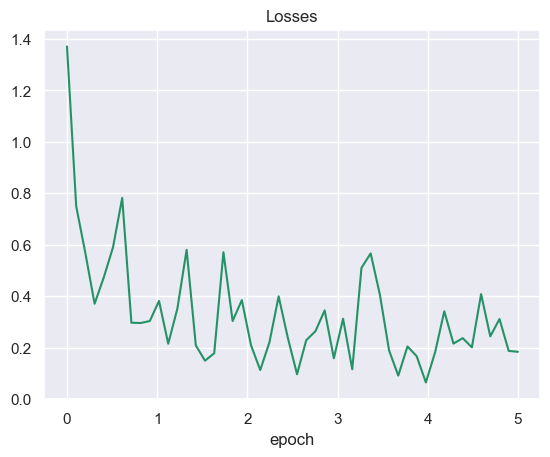

In [ ]:
plt.plot(np.linspace(0, num_epochs, len(losses)), losses)
plt.title('Losses')
plt.xlabel("epoch")
plt.show()

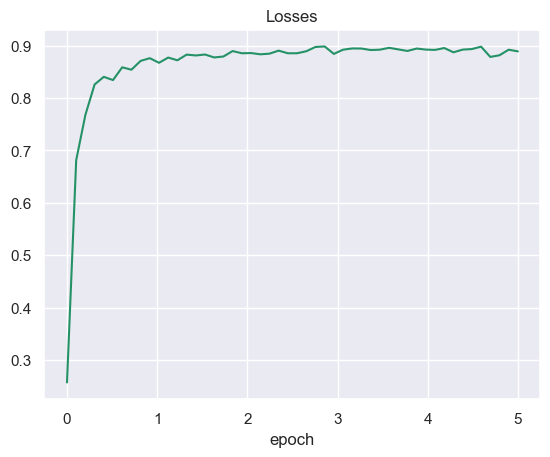

In [ ]:
plt.plot(np.linspace(0, num_epochs, len(acc)), acc)
plt.title('Losses')
plt.xlabel("epoch")
plt.show()

In [ ]:
model.eval()
print(evaluate(model, eval_dataloader))

0.8845999836921692


Эксперимент №6 - использование GRU вместо обычной RNN

In [ ]:
class GRU(nn.Module):
  def __init__(self, emb_dim : int, vocab_size : int, num_classes : int,
               aggregation_type : str = "max"):
    super().__init__()
    self.embeddings = nn.Embedding(vocab_size, emb_dim)
    self.rnn = nn.GRU(emb_dim, emb_dim, batch_first=True)
    self.linear = nn.Linear(emb_dim, emb_dim)
    self.final = nn.Linear(emb_dim, num_classes)

    self.activation = nn.Tanh()
    self.dropout = nn.Dropout(p=0.1)

    self.aggregation_type = aggregation_type

  def forward(self, x) -> torch.Tensor:
    embeddings = self.embeddings(x)
    output, _ = self.rnn(embeddings)

    if self.aggregation_type == 'max':
        output = output.max(dim=1)[0]
    elif self.aggregation_type == 'mean':
        output = output.mean(dim=1)
    else:
        raise ValueError("Invalid aggregation_type")

    output = self.activation(output)
    output = self.activation(self.dropout(self.linear(output)))
    output = self.final(output)

    return output

In [ ]:
num_epochs = 5
eval_steps = len(train_dataloader) // 10

losses = []
acc = []
model = GRU(emb_dim=256, vocab_size=len(vocab), num_classes=4, aggregation_type="mean").to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind["<pad>"])
optimizer = torch.optim.Adam(model.parameters())

for epoch in range(num_epochs):
    epoch_losses = []
    model.train()
    for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch + 1}:')):
      model.train()
      optimizer.zero_grad()
      predictions = model(batch["input_ids"])
      loss = criterion(predictions, batch["label"])
      loss.backward()
      optimizer.step()

      if i % eval_steps == 0:
          model.eval()
          losses.append(loss.item())
          acc.append(evaluate(model, eval_dataloader))

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/3750 [00:00<?, ?it/s]

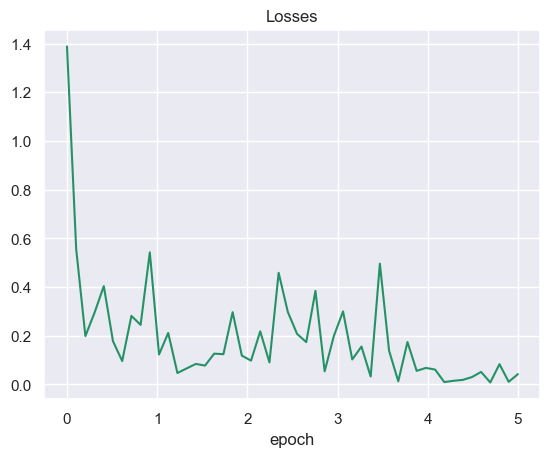

In [ ]:
plt.plot(np.linspace(0, num_epochs, len(losses)), losses)
plt.title('Losses')
plt.xlabel("epoch")
plt.show()

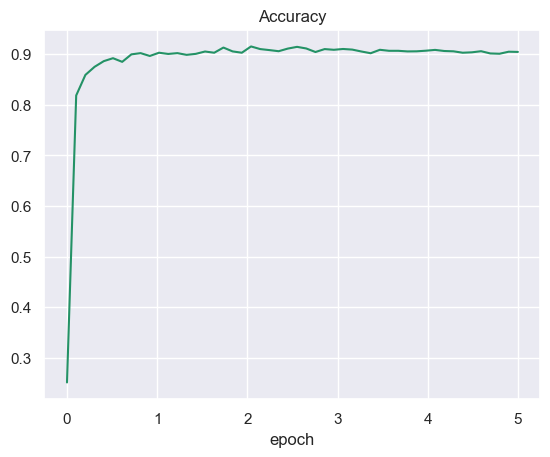

In [ ]:
plt.plot(np.linspace(0, num_epochs, len(acc)), acc)
plt.title('Accuracy')
plt.xlabel("epoch")
plt.show()

In [ ]:
model.eval()
print(evaluate(model, eval_dataloader))

0.9017999768257141


Эксперимент №7 - использование комбинации нескольких экспериментов, которые дали лучший результат

In [ ]:
class LSTM(nn.Module):
  def __init__(self, emb_dim : int, vocab_size : int, num_classes : int,
               aggregation_type : str = "max"):
    super().__init__()
    self.embeddings = nn.Embedding(vocab_size, emb_dim)
    self.rnn = nn.LSTM(emb_dim, emb_dim, num_layers=3, batch_first=True)
    self.linear = nn.Linear(emb_dim, emb_dim)
    self.final = nn.Linear(emb_dim, num_classes)

    self.activation = nn.Tanh()
    self.dropout = nn.Dropout(p=0.5)

    self.aggregation_type = aggregation_type

  def forward(self, x) -> torch.Tensor:
    embeddings = self.embeddings(x)
    output, _ = self.rnn(embeddings)

    if self.aggregation_type == 'max':
        output = output.max(dim=1)[0]
    elif self.aggregation_type == 'mean':
        output = output.mean(dim=1)
    else:
        raise ValueError("Invalid aggregation_type")

    output = self.dropout(output)
    output = self.activation(output)
    output = self.activation(self.dropout(self.linear(output)))
    output = self.final(output)

    return output

In [ ]:
num_epochs = 12
eval_steps = len(train_dataloader) // 10

losses = []
acc = []
model = LSTM(emb_dim=400, vocab_size=len(vocab), num_classes=4, aggregation_type="max").to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind["<pad>"])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))

for epoch in range(num_epochs):
    epoch_losses = []
    model.train()
    for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch + 1}:')):
      model.train()
      optimizer.zero_grad()
      predictions = model(batch["input_ids"])
      loss = criterion(predictions, batch["label"])
      loss.backward()
      optimizer.step()

      if i % eval_steps == 0:
          model.eval()
          losses.append(loss.item())
          acc.append(evaluate(model, eval_dataloader))

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 10::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 11::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 12::   0%|          | 0/3750 [00:00<?, ?it/s]

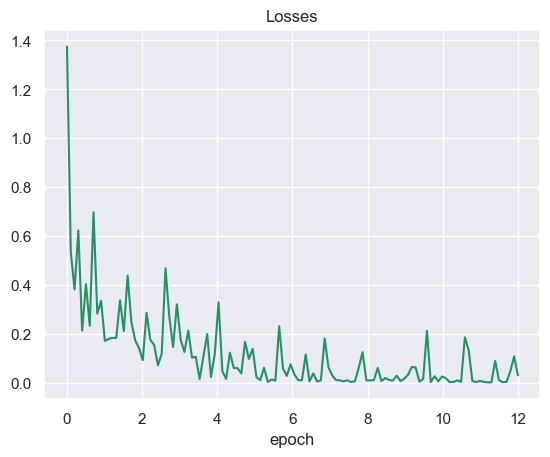

In [ ]:
plt.plot(np.linspace(0, num_epochs, len(losses)), losses)
plt.title('Losses')
plt.xlabel("epoch")
plt.show()

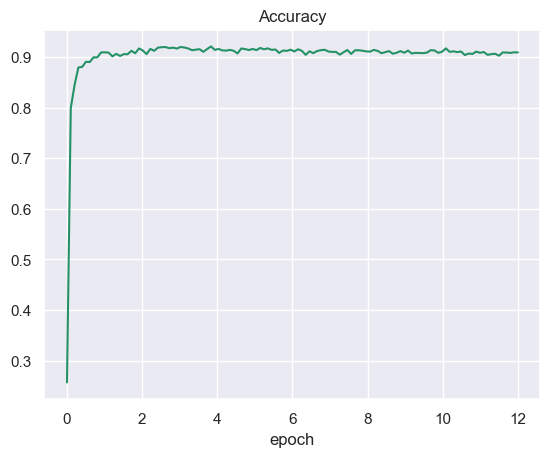

In [ ]:
plt.plot(np.linspace(0, num_epochs, len(acc)), acc)
plt.title('Accuracy')
plt.xlabel("epoch")
plt.show()

In [ ]:
model.eval()
print(evaluate(model, eval_dataloader))

0.9111999869346619


Вывод:

1 опыт показал, что использование большего количества эпох с базовой модели не имеет никакой прибавке к результату, т.к. базовая модель за небольшое количество эпох исчерпывает свою обобщающую способность и в дальнейшем идет в сторону переобучения

2 опыт продемонстрировал, что использование большей вероятности dropout ведет к лучшей сходимости модели и ее стабильности

3 опыт показал, что использование маленького learning rate ведет к более медленной сходимости модели и использовать такой подход стоит только с увеличением количеством эпох на обучении

4 опыт дал понять, что использование большего размерности эмбеддингов улучшает обобщающую способность модели, но не намного

в 5 опыте видно, что увеличение число слоев в рекуррентной части модели ведет к переобучению из-за внушительного увеличения параметров для обучения

в 6 опыте после применения GRU вместо обычной рекуррентной сети немного улучшается результат, но не внушительно, скорее всего, это происходит, т.к. размеры текстов достаточно малы, чтобы появилась большая проблема с краткосрочностью памяти у обычной модели

Каждый эксперимент дает небольшой прирост к результату модели, поэтому я постарался в 7 опыте совместить некоторые хорошие решения и получил accuracy: 0.911

В комбинации с 12 эпохами обучения, небольшим learning rate, большим размеров эмбеддингов и архитектурой LSTM с 3 рекуррентными слоями (из-за этого пришлось добавить второй dropout после выхода рекуррентной части, чтобы избежать переобучения) удалось избежать переобучения, стабильной сходимости и хорошей обобщающей способностью модели